# Sourcepredict example2: Estimating source proportions

For this example, we'll reuse the dog, human, and soil dataset.  
But unlike [example1](https://sourcepredict.readthedocs.io/en/latest/run_example.html), here we will mix samples from different sources and estimate the mixing proportions with Sourcepredict and Sourcetracker2

## Preparing mixed samples

In [1]:
import pandas as pd
from plotnine import *
import numpy as np

In [2]:
cnt = pd.read_csv("../data/modern_gut_microbiomes_sources.csv", index_col=0)
labels = pd.read_csv("../data/modern_gut_microbiomes_labels.csv",index_col=0)

As in example 1, we'll first split the dataset into training (95%) and testing(5%)

In [3]:
cnt_train = cnt.sample(frac=0.95, axis=1, random_state=42)
cnt_test = cnt.drop(cnt_train.columns, axis=1)
train_labels = labels.loc[cnt_train.columns,:]
test_labels = labels.loc[cnt_test.columns,:]

In [4]:
test_labels['labels'].value_counts()

Homo_sapiens        13
Canis_familiaris     8
Soil                 1
Name: labels, dtype: int64

In [5]:
cnt_test.head()

,SRR059440,SRR1930140,SRR1761708,SRR1761664,SRR1761667,SRR1761674,SRR7658684,SRR7658622,SRR7658689,SRR7658619,...,SRR5898940,ERR1914224,ERR1915611,ERR1915293,ERR1914207,ERR1915420,ERR1916218,ERR1913675,ERR1914667,SRR3578645
TAXID,,,,,,,,,,,,,,,,,,,,,
0,19805534.0,7267728.0,18530434.0,2460493.0,3324349.0,2835521.0,5565044.0,18783402.0,6319253.0,18641694.0,...,1658949.0,3442424.0,1529589.0,1765224.0,1815426.0,1364019.0,1558043.0,1617964.0,1557538.0,736.0
6,0.0,0.0,85.0,0.0,0.0,0.0,0.0,542.0,0.0,217.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,85.0,0.0,0.0,0.0,0.0,542.0,0.0,217.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,239.0,88.0,115.0,55.0,189.0,91.0,72.0,100.0,152.0,209.0,...,0.0,51.0,69.0,60.0,56.0,106.0,51.0,69.0,62.0,0.0
10,163.0,177.0,112.0,76.0,164.0,109.0,220.0,84.0,180.0,175.0,...,0.0,202.0,80.0,67.0,73.0,0.0,80.0,77.0,110.0,0.0


We then create a function to randomly select a sample from each source (dog as $s_{dog}$ and human as $s_{human}$), and combine such as the new sample $s_{mixed} = p1*s_{dog} + p1*s_{human}$

In [6]:
def create_mixed_sample(cnt, labels, p1, samp_name, seed):
    rand_dog = labels.query('labels == "Canis_familiaris"').sample(1, random_state = seed).index[0]
    rand_human = labels.query('labels == "Homo_sapiens"').sample(1, random_state = seed).index[0]
    dog_samp = cnt[rand_dog]*p1
    human_samp = cnt[rand_human]*(1-p1)
    comb = dog_samp + human_samp
    comb = comb.rename(samp_name)
    meta = pd.DataFrame({'human_sample':[rand_human],'dog_sample':[rand_dog], 'human_prop':[(1-p1)], 'dog_prop':[p1]}, index=[samp_name])
    return(comb, meta)

We run this function for a range of mixed proportions (0 to 100%, by 10%), 3 time for each mix

In [7]:
mixed_samp = []
mixed_meta = []
nb = 1
for i in range(3): 
    for p1 in np.arange(0,1.1,0.1):
        s = create_mixed_sample(cnt=cnt_test, labels=test_labels, p1=p1, samp_name=f"mixed_sample_{nb}", seed = int(100*p1))
        mixed_samp.append(s[0])
        mixed_meta.append(s[1])
        nb += 1

In [8]:
mixed_samples = pd.concat(mixed_samp, axis=1, keys=[s.name for s in mixed_samp]).astype(int)
mixed_samples.head()

,mixed_sample_1,mixed_sample_2,mixed_sample_3,mixed_sample_4,mixed_sample_5,mixed_sample_6,mixed_sample_7,mixed_sample_8,mixed_sample_9,mixed_sample_10,...,mixed_sample_24,mixed_sample_25,mixed_sample_26,mixed_sample_27,mixed_sample_28,mixed_sample_29,mixed_sample_30,mixed_sample_31,mixed_sample_32,mixed_sample_33
TAXID,,,,,,,,,,,,,,,,,,,,,
0,5565044,2390966,15338330,14408501,7983985,5100662,8740624,3251030,3418809,2103402,...,2390966,15338330,14408501,7983985,5100662,8740624,3251030,3418809,2103402,1529589
6,0,0,433,0,66,26,0,0,0,0,...,0,433,0,66,26,0,0,0,0,0
7,0,0,433,0,66,26,0,0,0,0,...,0,433,0,66,26,0,0,0,0,0
9,72,55,90,184,98,141,159,74,78,70,...,55,90,184,98,141,159,74,78,70,69
10,220,75,83,136,276,117,65,109,194,89,...,75,83,136,276,117,65,109,194,89,80


In [9]:
mixed_metadata = pd.concat(mixed_meta)
mixed_metadata

,human_sample,dog_sample,human_prop,dog_prop
mixed_sample_1,SRR7658684,ERR1913675,1.0,0.0
mixed_sample_2,SRR1761664,ERR1915293,0.9,0.1
mixed_sample_3,SRR7658622,ERR1916218,0.8,0.2
mixed_sample_4,SRR059440,ERR1914207,0.7,0.3
mixed_sample_5,SRR7658624,ERR1914667,0.6,0.4
mixed_sample_6,SRR7658608,ERR1915420,0.5,0.5
mixed_sample_7,SRR059440,ERR1915420,0.4,0.6
mixed_sample_8,SRR1930140,ERR1915611,0.3,0.7
mixed_sample_9,SRR1761667,ERR1914224,0.2,0.8
mixed_sample_10,SRR1930140,ERR1915611,0.1,0.9


Now we can export the new "test" (sink) table to `csv` for sourcepredict

In [10]:
mixed_samples.to_csv('mixed_samples_cnt.csv')

As well as the source count and labels table for the sources

In [11]:
train_labels.to_csv('train_labels.csv')
cnt_train.to_csv('sources_cnt.csv')

## Sourcepredict

### With KNN machine learning

For running Sourcepredict, we'll change two parameters from their default values:
- `-me` The default method used by Sourcepredict is T-SNE which a non-linear type of embedding, i.e. the distance between points doesn't reflext their actual distance in the original dimensions, to achieve a better clustering, which is good for source prediction. Because here we're more interested in source proportion estimation, rather than source prediction, we'll choose a Multi Dimensional Scaling (MDS) which is a type of linear embedding, where the distance between points in the lower dimension match more the distances in the embedding in lower dimension, which is better for source proportion estimation.
- `-kne` which is the number of neighbors in KNN algorithm: we use all neighbors to reflect a more global contribution of samples to the proportion estimation, instead of only the immediate neighbors. This will affect negatively the source prediction, but give better source proportion estimations

In [12]:
%%time
!python ../sourcepredict -s sources_cnt.csv \
               -l train_labels.csv \
               -kne all\
               -me mds \
               -e mixed_embedding.csv \
               -t 6 \
               mixed_samples_cnt.csv

Traceback (most recent call last):
  File "../sourcepredict", line 4, in <module>
    from sourcepredictlib.ml import sourceunknown
  File "/Users/borry/Documents/GitHub/sourcepredict/sourcepredictlib/ml.py", line 371
    if neighbors == 'all'
                        ^
SyntaxError: invalid syntax
CPU times: user 3.73 ms, sys: 7.14 ms, total: 10.9 ms
Wall time: 167 ms


**Reading Sourcepredict KNN results**

In [13]:
sp_ebd = pd.read_csv("mixed_embedding.csv", index_col=0)

In [14]:
sp_ebd.head()

,PC1,PC2,labels,name
mgm4477874_3,8.822395,-4.957090,Soil,mgm4477874_3
SRR1761709,3.896029,6.258361,Homo_sapiens,SRR1761709
SRR7658685,-1.151347,5.457706,Homo_sapiens,SRR7658685
SRR059395,-0.889409,-7.682652,Homo_sapiens,SRR059395
ERR1915122,-3.533856,-2.673234,Canis_familiaris,ERR1915122


In [15]:
import warnings
warnings.filterwarnings('ignore')

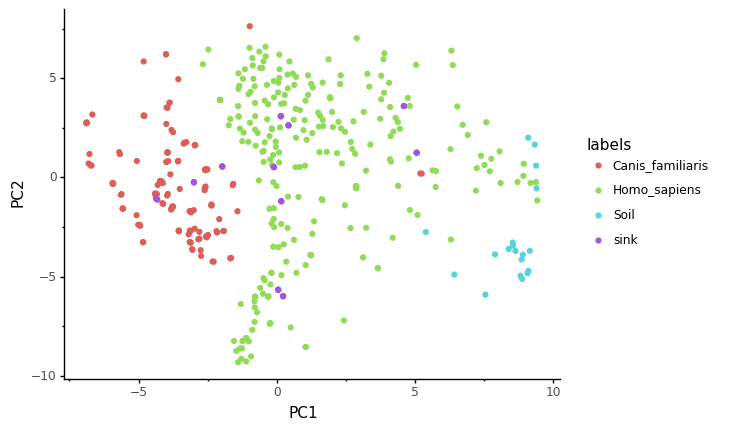

<ggplot: (292803357)>

In [16]:
ggplot(data = sp_ebd, mapping = aes(x='PC1',y='PC2')) + geom_point(aes(color='labels')) + theme_classic()

In [17]:
sp_pred = pd.read_csv("mixed_samples_cnt.sourcepredict.csv", index_col=0)

In [18]:
sp_pred.T.head()

,Canis_familiaris,Homo_sapiens,Soil,unknown
mixed_sample_1,0.168381,0.800145,0.016322,0.015152
mixed_sample_2,0.136828,0.822562,0.025459,0.015152
mixed_sample_3,0.214168,0.739634,0.031122,0.015075
mixed_sample_4,0.262756,0.709232,0.012864,0.015148
mixed_sample_5,0.213047,0.733132,0.038669,0.015152


In [19]:
mixed_metadata.head()

,human_sample,dog_sample,human_prop,dog_prop
mixed_sample_1,SRR7658684,ERR1913675,1.0,0.0
mixed_sample_2,SRR1761664,ERR1915293,0.9,0.1
mixed_sample_3,SRR7658622,ERR1916218,0.8,0.2
mixed_sample_4,SRR059440,ERR1914207,0.7,0.3
mixed_sample_5,SRR7658624,ERR1914667,0.6,0.4


In [20]:
sp_res = sp_pred.T.merge(mixed_metadata, left_index=True, right_index=True)

In [21]:
from sklearn.metrics import r2_score, mean_squared_error

In [22]:
mse_sp = round(mean_squared_error(y_pred=sp_res['Homo_sapiens'], y_true=sp_res['human_prop']),2)
r2_sp = round(r2_score(y_pred=sp_res['Homo_sapiens'], y_true=sp_res['human_prop']),2)

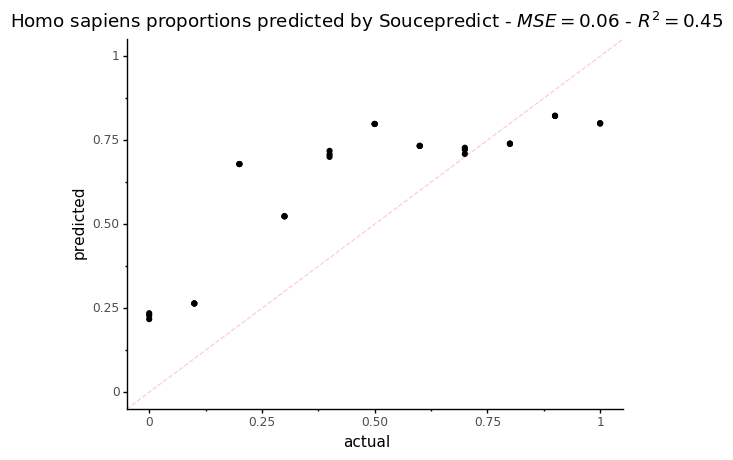

<ggplot: (292754843)>

In [23]:
p = ggplot(data = sp_res, mapping=aes(x='human_prop',y='Homo_sapiens')) + geom_point()
p += labs(title = f"Homo sapiens proportions predicted by Soucepredict - $MSE = {mse_sp}$ - $R^2 = {r2_sp}$", x='actual', y='predicted') 
p += theme_classic() 
p += coord_cartesian(xlim=[0,1], ylim=[0,1])
p += geom_abline(intercept=0, slope=1, color = "red", alpha=0.2, linetype = 'dashed')
p

On this plot, the dotted red line represents what a perfect proportion estimation would give

In [24]:
sp_res_hist = (sp_res['human_prop'].append(sp_res['Homo_sapiens']).to_frame(name='Homo_sapiens_prop'))
sp_res_hist['source'] = (['actual']*sp_res.shape[0]+['predicted']*sp_res.shape[0])

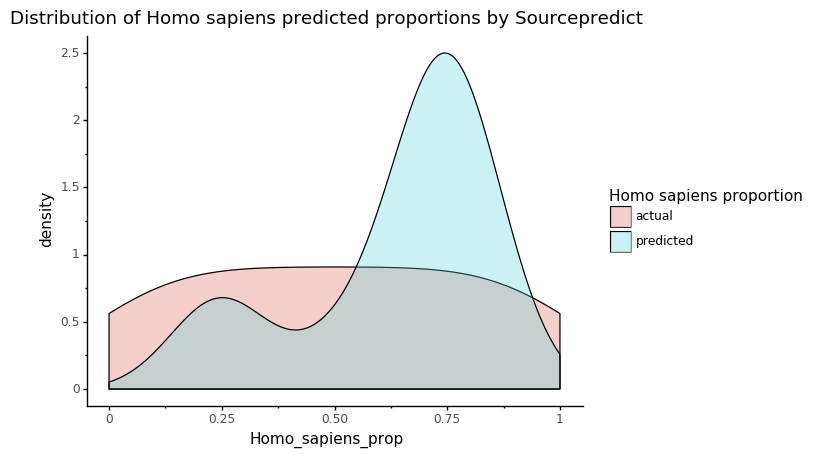

<ggplot: (-9223372036562007506)>

In [25]:
p = ggplot(data = sp_res_hist, mapping=aes(x='Homo_sapiens_prop')) + geom_density(aes(fill='source'), alpha=0.3)
p += labs(title = 'Distribution of Homo sapiens predicted proportions by Sourcepredict') 
p += scale_fill_discrete(name="Homo sapiens proportion")
p += theme_classic() 
p

This plot shows the actual and predicted by Sourcepredict distribution of Human proportions. What we are interested in is the overlap between the two colors: the higher it is, the more the estimated Human proportion is accurate.

## Sourcetracker2

Preparing count table

In [26]:
cnt_train.merge(mixed_samples, right_index=True, left_index=True).to_csv("st_mixed_count.csv" , sep="\t", index_label="TAXID")

In [27]:
!biom convert -i st_mixed_count.csv -o st_mixed_count.biom --table-type="Taxon table" --to-json

Preparing metadata

In [28]:
train_labels['SourceSink'] = ['source']*train_labels.shape[0]

In [29]:
mixed_metadata['labels'] = ['-']*mixed_metadata.shape[0]
mixed_metadata['SourceSink'] = ['sink']*mixed_metadata.shape[0]

In [30]:
st_labels = train_labels.append(mixed_metadata[['labels', 'SourceSink']])

In [31]:
st_labels = st_labels.rename(columns={'labels':'Env'})[['SourceSink','Env']]

In [32]:
st_labels.to_csv("st_mixed_labels.csv", sep="\t", index_label='#SampleID')

Running Sourcetracker2 `sourcetracker2 gibbs -i st_mixed_count.biom -m st_mixed_labels.csv -o mixed_prop --jobs 6`  
(Sourcetracker2 was run on a Linux remote server because of issues running it on MacOS)

Sourcetracker2 results

In [33]:
st_pred = pd.read_csv("_assets/mixed_prop/mixing_proportions.txt", sep="\t", index_col=0)

In [34]:
st_res = st_pred.merge(mixed_metadata, left_index=True, right_index=True)

In [35]:
mse_st = round(mean_squared_error(y_pred=st_res['Homo_sapiens'], y_true=st_res['human_prop']),2)
r2_st = round(r2_score(y_pred=st_res['Homo_sapiens'], y_true=st_res['human_prop']),2)

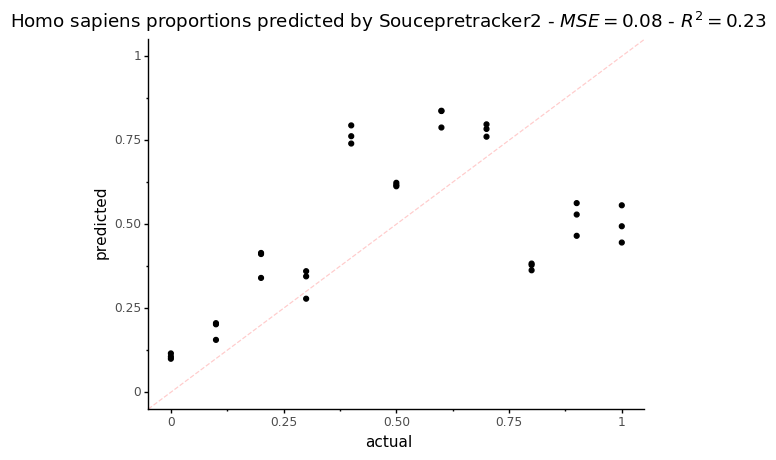

<ggplot: (-9223372036561956748)>

In [36]:
p = ggplot(data = st_res, mapping=aes(x='human_prop',y='Homo_sapiens')) + geom_point()
p += labs(title = f"Homo sapiens proportions predicted by Soucepretracker2 - $MSE = {mse_st}$ - $R^2 = {r2_st}$", x='actual', y='predicted') 
p += theme_classic() 
p += coord_cartesian(xlim=[0,1], ylim=[0,1])
p += geom_abline(intercept=0, slope=1, color = "red", alpha=0.2, linetype = 'dashed')
p

On this plot, the dotted red line represents what a perfect proportion estimation would give.

In [37]:
st_res_hist = (st_res['human_prop'].append(st_res['Homo_sapiens']).to_frame(name='Homo_sapiens_prop'))
st_res_hist['source'] = (['actual']*st_res.shape[0]+['predicted']*st_res.shape[0])

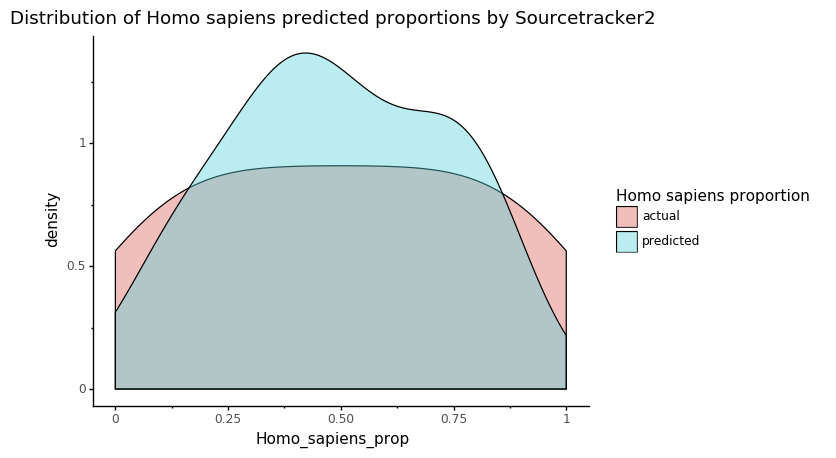

<ggplot: (296769698)>

In [38]:
p = ggplot(data = st_res_hist, mapping=aes(x='Homo_sapiens_prop')) + geom_density(aes(fill='source'), alpha=0.4)
p += labs(title = 'Distribution of Homo sapiens predicted proportions by Sourcetracker2') 
p += scale_fill_discrete(name="Homo sapiens proportion")
p += theme_classic() 
p

This plot shows the actual and predicted by Sourcepredict distribution of Human proportions. What we are interested in is the overlap between the two colors: the higher it is, the more the estimated Human proportion is accurate.

## Conclusion
For source proportion estimation in samples of mixed sources, Sourcepredict, especially when using it with `-kne all` neighbors, performs similarly, or slightly better than Sourcetracker2.  
However, Sourcepredict wasn't designed for source prediction in mind, as opposed to source proportion estimation. Therefore, for source proportion estimation, we still recommend using Sourcetracker2, even if Sourcepredict can perform similarly.